In [ ]:
!pip install kaggle #Data extraction
!pip install segmentation_models #Library with neural network models for image segmentation
!pip install keras
!pip install -U keras-tuner #Library used in parameter optimization
%env SM_FRAMEWORK=tf.keras
%matplotlib inline

In [ ]:
import os
import sys
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import matplotlib.image as mpimg
import matplotlib.pyplot
from PIL import Image

In [ ]:
#path to dataset
import os
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
path_dataset = '/content/gdrive/My Drive/Doutorado/Bases/GAMMA_training_data/multi-modality_images/'
os.chdir(path_dataset)

Mounted at /content/gdrive


# Data Generators

In [ ]:
#for training
class DataGen(keras.utils.Sequence):  #Instância do data generator
    def __init__(self, ids, path, batch_size=8, image_size=256): #Initialize data
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()

    def __load__(self, id_name): #load images

        image_path = os.path.join(self.path, "", id_name) + ".jpg" #load images

        mask_path = os.path.join(self.path, "Disc_Cup_Mask", id_name) + ".png" #load masks

        #image = metodoClahe(image_path)#preprocess for blood vessels

        image = cv2.imread(image_path, 1) #read images
        b,g,r = cv2.split(image)
        image = cv2.merge([r,g,b])

        #normalize
        image = cv2.resize(image, (self.image_size, self.image_size))#
        mask = np.zeros((self.image_size, self.image_size, 1))#Setting the size of each channel
        _mask = cv2.imread(mask_path, -1)#equals to cv2.IMREAD_UNCHANGED
        _mask = cv2.resize(_mask, (self.image_size, self.image_size))#
        _mask = np.expand_dims(_mask, axis=-1)
        mask = np.maximum(mask, _mask)
        #Normalize
        image = image/255.0
        mask = mask/255.0

        return image, mask

    def __getitem__(self, index): #Function that will take an image from the generator, passing its index as a parameter
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size

        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]

        image = []
        mask  = []

        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)

        image = np.array(image)
        mask  = np.array(mask)
        return image, mask

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [ ]:
#for test set (without masks)
class DataGenVal(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=256):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()

    def __load__(self, id_name):
        image_path = os.path.join(self.path, "", id_name) + ".jpg" #load images

        #Reading and converting the image to RGB (Disc Segmentation)
        image = cv2.imread(image_path, 1) #
        b,g,r = cv2.split(image)
        image = cv2.merge([r,g,b])
        #
        image = cv2.resize(image, (self.image_size, self.image_size))

        image = image/255.0

        return image

    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size

        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]

        image = []

        for id_name in files_batch:
            _img = self.__load__(id_name)
            image.append(_img)

        image = np.array(image)

        return image

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

# Organize Files

In [ ]:
image_size = 256 #Choose a multiple value of 32
train_path = "./fundus_images" #path to train set
#test_path = "./Teste" #path to test set
batch_size = 2


train_ids = []
for files in os.walk(train_path):
   for name in files:
      train_ids.append(name)

train_ids = train_ids[2]#file names
train_ids = [i.split('.', 1)[0] for i in train_ids]#separate name (IDS) from suffix (.png)

In [ ]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)#read images
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(2, 256, 256, 3) (2, 256, 256, 1)


# Read one image

1


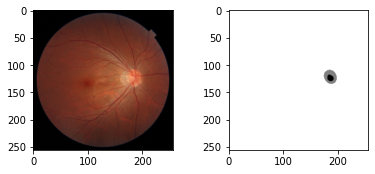

In [ ]:
#Verifying that the image was read successfully
r = random.randint(0, len(x)-1)#Random number to fetch an image to test
print(r)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)#Adjusting the image plot layout
ax = fig.add_subplot(1, 2, 1)#Image 1
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)#Image 2 (mask)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

In [ ]:
import keras
import segmentation_models as sm
from keras.losses import binary_crossentropy
from keras import backend as K
from tensorflow.keras import layers
#from kerastuner.tuners import RandomSearch
#import kerastuner as kt
from sklearn import ensemble
from sklearn import datasets
from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
import segmentation_models as sm
from tensorflow.keras.optimizers import SGD, Adam

Segmentation Models: using `tf.keras` framework.


# Loss Functions

In [ ]:
import keras
import segmentation_models as sm
from keras.losses import binary_crossentropy
from keras import backend as K
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
import segmentation_models as sm
import kerastuner as kt
from sklearn import ensemble
from sklearn import datasets
from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection

 #Setting extra loss functions (which don't belong in the Python libraries) for testing
def DiceBCELoss(targets, inputs, smooth=1e-6):

  #flatten label and prediction tensors
  inputs = K.flatten(inputs)
  targets = K.flatten(targets)

  BCE =  sm.losses.BinaryCELoss(targets, inputs)
  intersection = K.sum(K.dot(targets, inputs))
  dice_loss = sm.losses.bce_dice_loss
  Dice_BCE = BCE + dice_loss

  return Dice_BCE

def TverskyLoss(targets, inputs, alpha=0.5, beta=0.5, smooth=1e-6):

  #flatten label and prediction tensors
  inputs = K.flatten(inputs)
  targets = K.flatten(targets)

  #True Positives, False Positives & False Negatives
  TP = K.sum((inputs * targets))
  FP = K.sum(((1-targets) * inputs))
  FN = K.sum((targets * (1-inputs)))

  Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)

  return 1 - Tversky

Segmentation Models: using `tf.keras` framework.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


# Models

# Base U- NET

In [ ]:
#Build a base U_net
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))

    p0 = inputs
    c1, p1 = down_block(p0, f[0])
    c2, p2 = down_block(p1, f[1])
    c3, p3 = down_block(p2, f[2])
    c4, p4 = down_block(p3, f[3])

    bn = bottleneck(p4, f[4])

    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128

    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

UNET - VGG 16

In [ ]:
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from keras.models import Model
from keras.applications.vgg16 import VGG16

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_vgg16_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG16 Model """
    vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = vgg16.get_layer("block1_conv2").output         ## (512 x 512)
    s2 = vgg16.get_layer("block2_conv2").output         ## (256 x 256)
    s3 = vgg16.get_layer("block3_conv3").output         ## (128 x 128)
    s4 = vgg16.get_layer("block4_conv3").output         ## (64 x 64)

    """ Bridge """
    b1 = vgg16.get_layer("block5_conv3").output         ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG16_U-Net")
    return model

if __name__ == "__main__":
    input_shape = (image_size, image_size, 3)
    model = build_vgg16_unet(input_shape)
    #model.summary()

UNET DenseNet121

In [ ]:
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from keras.models import Model
from keras.applications.densenet import DenseNet121

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_densenet121_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained DenseNet121 Model """
    densenet = DenseNet121(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = densenet.get_layer("input_1").output       ## 512
    s2 = densenet.get_layer("conv1/relu").output    ## 256
    s3 = densenet.get_layer("pool2_relu").output ## 128
    s4 = densenet.get_layer("pool3_relu").output  ## 64

    """ Bridge """
    b1 = densenet.get_layer("pool4_relu").output  ## 32

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)             ## 64
    d2 = decoder_block(d1, s3, 256)             ## 128
    d3 = decoder_block(d2, s2, 128)             ## 256
    d4 = decoder_block(d3, s1, 64)              ## 512

    """ Outputs """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs)
    return model


if __name__ == "__main__":
    input_shape = (image_size, image_size, 3)
    model = build_densenet121_unet(input_shape)
    #model.summary()

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)#visualize model

In [ ]:
#model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.compile(optimizer=SGD(learning_rate=1e-4, momentum=0.95),
              loss=sm.losses.bce_dice_loss,
              #metrics=[mean_IOU_gpu, dice_metric])
              metrics = sm.metrics.iou_score)

#model.summary()

#train_gen = DataGen(train_ids, train_path)
train_gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)#Reading the images using the data generator
train_steps = len(train_ids)//batch_size
model.fit(train_gen, steps_per_epoch=train_steps, epochs = 100)

Pre-Trained Model

In [ ]:
#load pre-trained model

os.environ['KAGGLE_USERNAME'] = "lucascunhadecarvalho"
os.environ['KAGGLE_KEY'] = "66aee9f83fd989281d28d8832f428c68"

def baixaModelos ():
  !kaggle datasets download -d lucascunhadecarvalho/modelostreinadossegmentacao #Dataset used in vein segmentation
  !unzip -q modelostreinadossegmentacao

#classData () #If you want to perform the classification of eye fundus structures
#classDataRimOne ()
#baixaModelos() #Downloading the segmentation trained models - segmentation files

from keras.models import load_model
model = load_model('Modelo_DO.h5', custom_objects={'binary_crossentropy_plus_dice_loss': sm.losses.bce_dice_loss,
                                                      'iou_score': sm.metrics.iou_score,
                                                      'f1-score': sm.metrics.f1_score})



In [ ]:
#acc/loss threshold
from keras.callbacks import EarlyStopping
class MyThresholdCallback(EarlyStopping):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        #accuracy = (logs["glaucoma_acc"] + logs["estagio_acc"])/2
        #accuracy = logs["acc"]
        loss = logs["loss"]
        if loss <= self.threshold:
            self.model.stop_training = True

In [ ]:
es=MyThresholdCallback(threshold=.1)#callback option for early stopping
callbacks=[es],

In [ ]:
#train and compile model
model.compile(optimizer=SGD(learning_rate=1e-4, momentum=0.95),
              loss=sm.losses.bce_dice_loss,
              #metrics=[mean_IOU_gpu, dice_metric])
              metrics = sm.metrics.iou_score)

train_gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)#Reading the images using the data generator
train_steps = len(train_ids)//batch_size
model.fit(train_gen, steps_per_epoch=train_steps, epochs = 100)

Epoch 1/100
50/50 [==============================] - 58s 648ms/step - loss: 11.1450 - iou_score: 0.0254
Epoch 2/100
50/50 [==============================] - 14s 269ms/step - loss: 5.6947 - iou_score: 0.0839
Epoch 3/100
50/50 [==============================] - 14s 279ms/step - loss: 2.3833 - iou_score: 0.3124
Epoch 4/100
50/50 [==============================] - 14s 277ms/step - loss: 0.8090 - iou_score: 0.6176
Epoch 5/100
50/50 [==============================] - 13s 266ms/step - loss: 0.3434 - iou_score: 0.8109
Epoch 6/100
50/50 [==============================] - 13s 267ms/step - loss: 0.2163 - iou_score: 0.8742
Epoch 7/100
50/50 [==============================] - 13s 265ms/step - loss: 0.1581 - iou_score: 0.9034
Epoch 8/100
50/50 [==============================] - 13s 265ms/step - loss: 0.1255 - iou_score: 0.9218
Epoch 9/100
50/50 [==============================] - 13s 265ms/step - loss: 0.1047 - iou_score: 0.9345
Epoch 10/100
50/50 [==============================] - 13s 264ms/step - l

# Test Set (Generate masks)

In [ ]:
from keras.models import load_model
os.chdir(path_dataset)
#model_disco = load_model('./UNET-VGG16.h5')

In [ ]:
val_path_dataset = '/content/gdrive/My Drive/Doutorado/Bases/GAMMA_val_data/multi-modality_images/'
os.chdir(val_path_dataset)

In [ ]:
val_path = "./fundus_images" #path to test set

val_ids = []
for files in os.walk(val_path):#traversing directories
   for name in files:
      val_ids.append(name)

val_ids = val_ids[2]#file names
val_ids = [i.split('.', 1)[0] for i in val_ids]#Separando os nomes (IDS) de seus sufixos (.png)

In [ ]:
os.mkdir('Masks_DO_V4')#folder in which masks will be saved

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


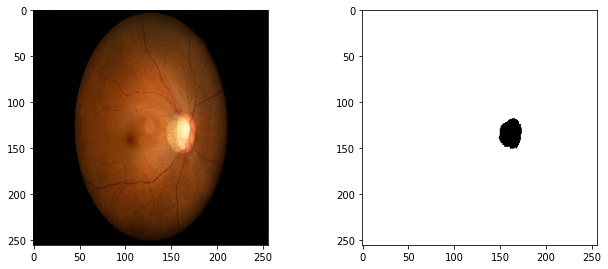

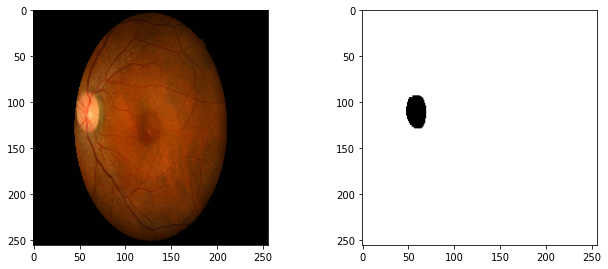

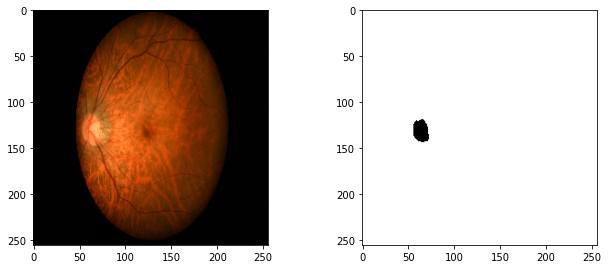

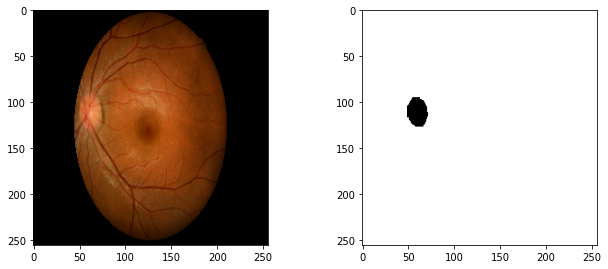

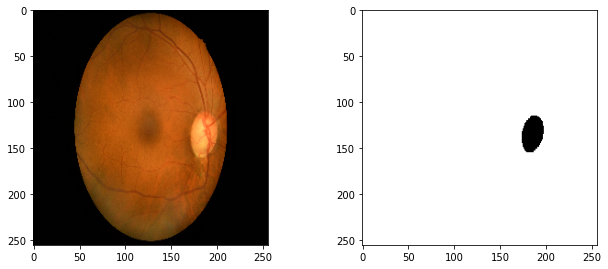

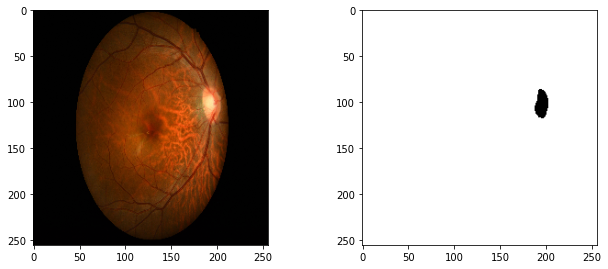

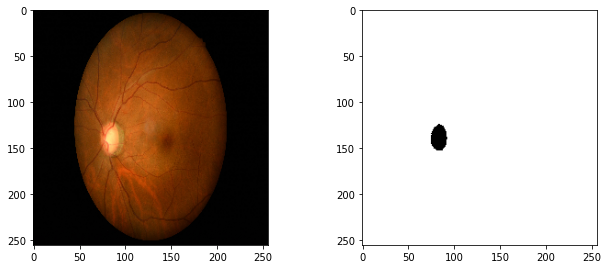

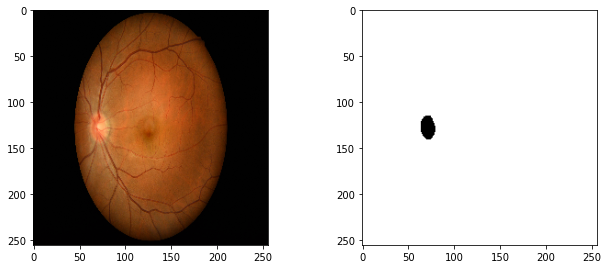

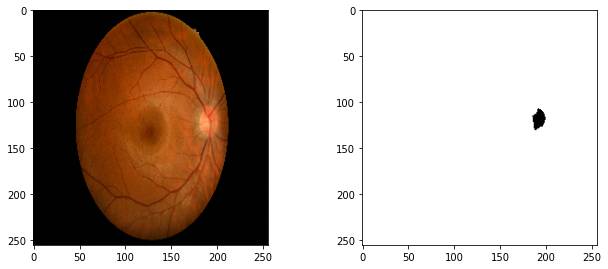

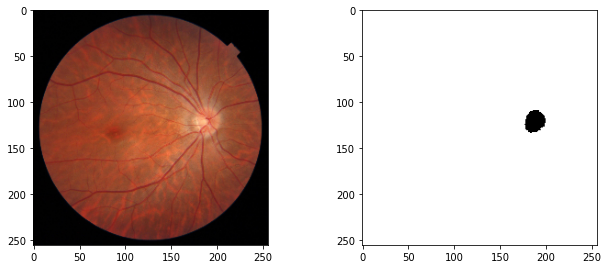

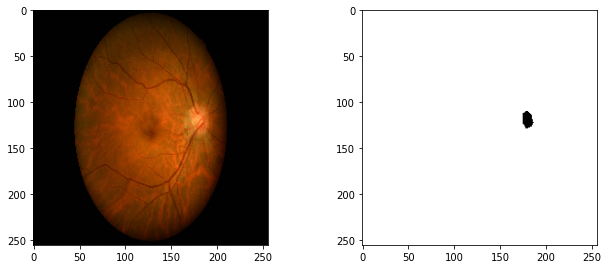

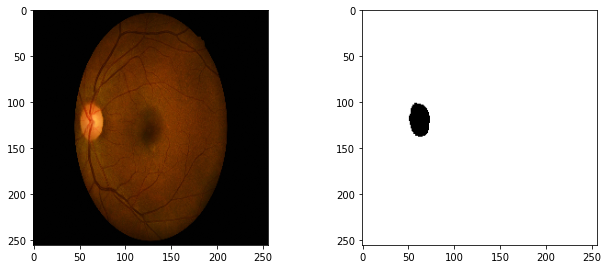

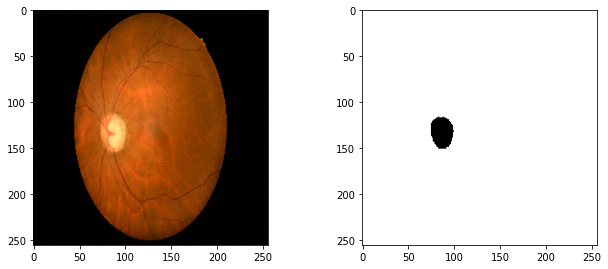

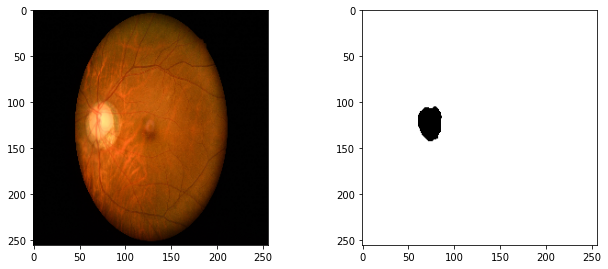

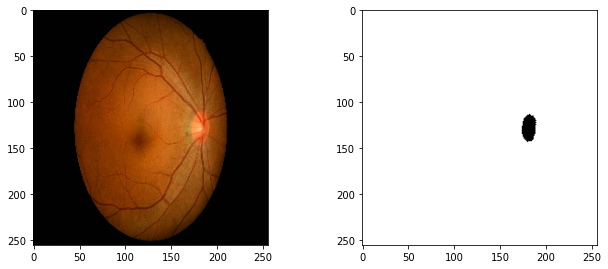

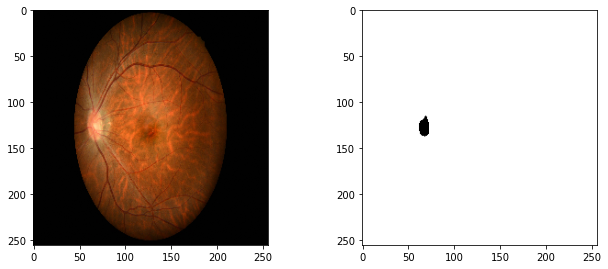

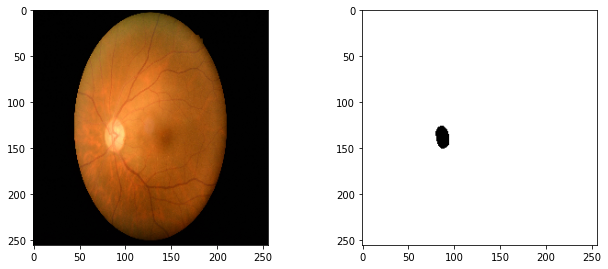

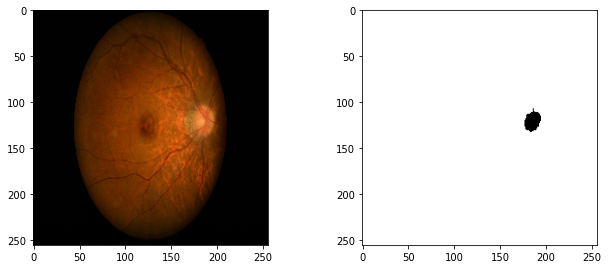

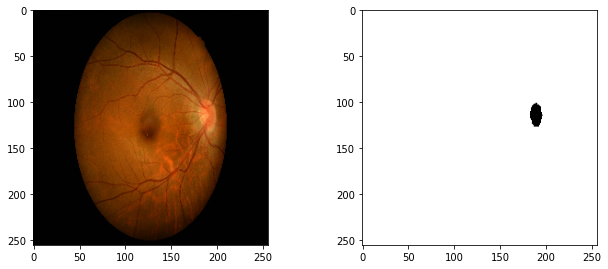

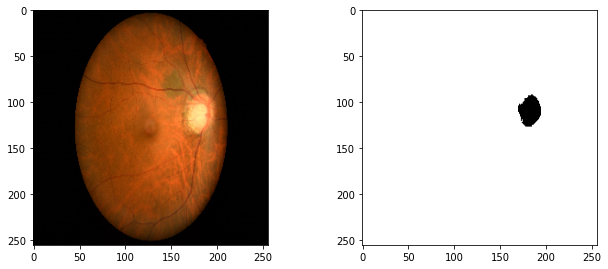

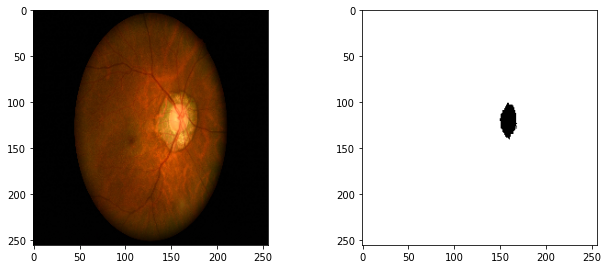

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

In [ ]:
def resultadosModeloSegmentacaoOdirDO (model):
  test_gen = DataGenVal(val_ids, val_path, 1, 256)
  show = 0

  for i in range(len(test_gen)):
    x = test_gen.__getitem__(i)
    result = model.predict(x)
    result = result > 0.5#???
    fig = plt.figure(figsize = (16,8))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    if show <= 20:#show 20 images
      ax = fig.add_subplot(1, 3, 1)
      ax.imshow(x[0])

      ax = fig.add_subplot(1, 3, 2)
      ax.imshow(np.reshape(result[0]*255, (256, 256)), cmap="gray")

    pred = np.dstack([result[0], result[0], result[0]])
    pred = (pred * 255).astype(np.uint8)

    nome_imagem = 'Masks_DO_V4/' + val_ids[i] + '.png'
    img = Image.fromarray(pred, 'RGB')
    img.save(nome_imagem)
    cv2.imwrite(nome_imagem, pred)
    im = Image.open(nome_imagem)
    im.save(nome_imagem, "png")
    show += 1

resultadosModeloSegmentacaoOdirDO (model)